# 時変係数モデル
説明変数を加えた動的線形モデルの一つ。説明変数の係数が時間に応じて変化するモデル。

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import stan
import nest_asyncio
nest_asyncio.apply()

In [4]:
sales = pd.read_csv('../data/4-4-sales-ts.csv')
sales['date'] = [datetime.strptime(i, "%Y-%m-%d") for i in sales["date"]]

In [5]:
sales

,date,sales,publicity
0,2010-01-01,95.8,0
1,2010-01-02,83.6,0
2,2010-01-03,94.1,0
3,2010-01-04,98.1,0
4,2010-01-05,122.8,1
...,...,...,...
95,2010-04-06,119.3,1
96,2010-04-07,131.9,4
97,2010-04-08,123.3,3
98,2010-04-09,109.4,0


時変係数モデルはランダムウォークする切片を持つローカルレベルモデルにランダムウォークする回帰係数を持つ説明変数を加えたモデルであり、次のように定式化される。
$$
\mu_t = \mu_{t-1} + w_t \qquad w_t \sim Normal(0, \sigma_w^2) \\
\beta_t = \beta_{t-1} + \tau_t \qquad \tau_t \sim Normal(0, \sigma_{\tau}^2) \\
\alpha_t = \mu_t + \beta_t x_t \\
\\
y_t = \alpha_t + v_t \qquad v_t \sim Normal(0, \sigma_v^2)
$$
このように切片と回帰係数が一つ前の時点に依存する。

In [6]:
y = sales['sales'].values
x = sales["publicity"].values
T = len(y)

In [7]:
stan_data = {
    'T': T,
    'y': y,
    'x': x
}

In [11]:
with open("../stan/4-4-time-varying-coef.stan", "r") as f:
    stan_code = f.read()

In [12]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/obc6b7un/model_obc6b7un.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 20.0s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [13]:
fit = sm.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:   0% (1/30000)
Sampling:   0% (2/30000)
Sampling:   0% (3/30000)
Sampling:   0% (102/30000)
Sampling:   1% (201/30000)
Sampling:   1% (300/30000)
Sampling:   1% (400/30000)
Sampling:   2% (500/30000)
Sampling:   2% (700/30000)
Sampling:   3% (900/30000)
Sampling:   4% (1100/30000)
Sampling:   4% (1200/30000)
Sampling:   5% (1400/30000)
Sampling:   5% (1600/30000)
Sampling:   6% (1800/30000)
Sampling:   6% (1900/30000)
Sampling:   7% (2100/30000)
Sampling:   7% (2200/30000)
Sampling:   8% (2400/30000)
Sampling:  10% (3000/30000)
Sampling:  13% (3900/30000)
Sampling:  22% (6500/30000)
Sampling:  34% (10300/30000)
Sampling:  50% (14900/30000)
Sampling:  61% (18200/30000)
Sampling:  73% (21800/30000)
Sampling:  79% (23800/30000)
Sampling:  88% (26300/30000)
Sampling:  92% (27500/30000)
Sampling:  98% (29300/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 0.0001 seconds
  1000 tran

In [14]:
summary = az.summary(fit, var_names=["mu", "b", "alpha", "s_w", "s_t", "s_v"])
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],96.707,5.990,84.973,107.495,0.127,0.091,2213.0,2752.0,1.00
mu[1],96.655,5.620,86.032,106.731,0.138,0.100,1647.0,524.0,1.00
mu[2],98.451,5.054,89.429,108.234,0.116,0.083,1919.0,2517.0,1.00
mu[3],100.761,4.663,91.694,109.018,0.097,0.070,2284.0,625.0,1.00
mu[4],103.345,4.502,94.702,111.263,0.089,0.064,2525.0,630.0,1.00
...,...,...,...,...,...,...,...,...,...
alpha[98],111.996,6.199,100.484,123.771,0.072,0.051,7395.0,8308.0,1.00
alpha[99],138.268,7.086,124.864,151.569,0.092,0.066,5952.0,6831.0,1.00
s_w,3.653,1.202,1.408,5.793,0.043,0.030,730.0,361.0,1.00
s_t,0.985,0.372,0.341,1.632,0.017,0.012,420.0,377.0,1.01


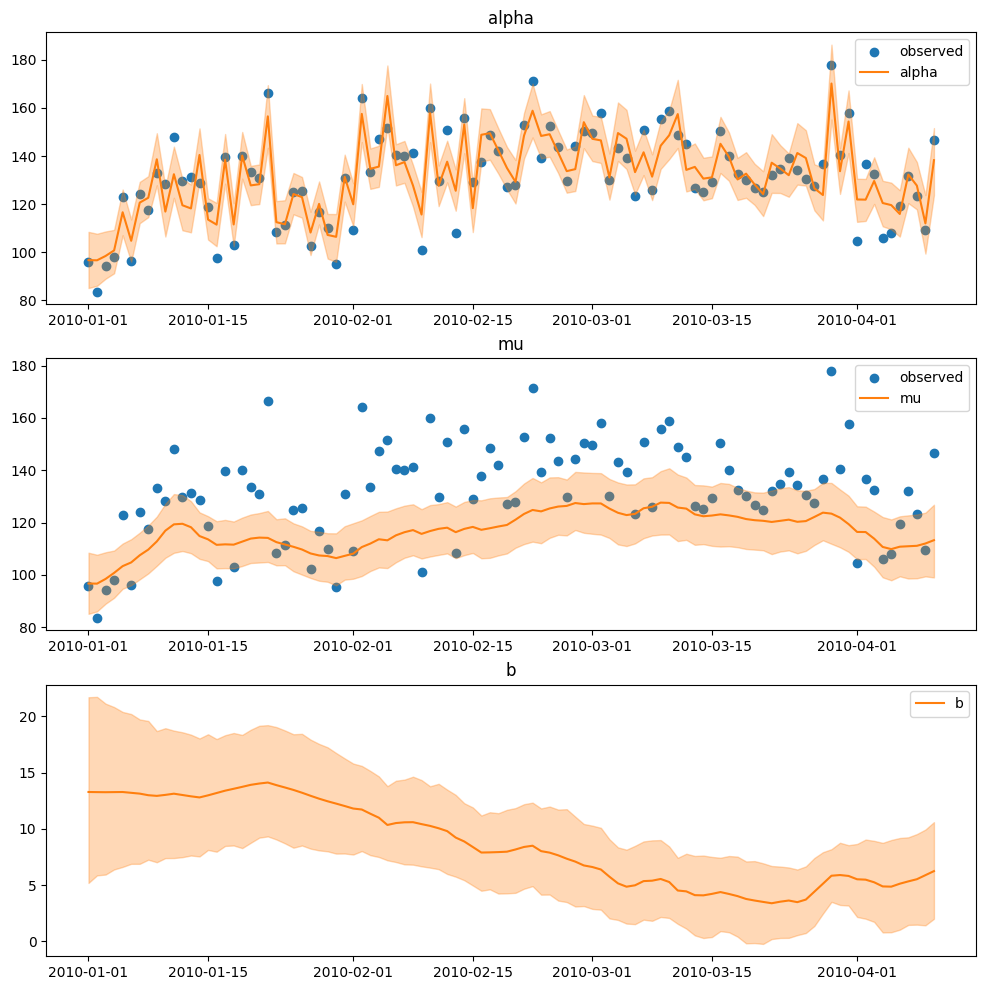

In [23]:
cmap = plt.get_cmap("tab10")

mu_mean = az.summary(fit, var_names=["mu"])["mean"].values
b_mean = az.summary(fit, var_names=["b"])["mean"].values
alpha_mean = az.summary(fit, var_names=["alpha"])["mean"].values

hdis = az.hdi(fit, var_names=["mu", "b", "alpha"], hdi_prob=0.95)
hdi_mu = hdis["mu"]
hdi_b = hdis["b"]
hdi_alpha = hdis["alpha"]

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
axes[0].scatter(sales["date"], sales["sales"], color=cmap(0), label="observed")
axes[1].scatter(sales["date"], sales["sales"], color=cmap(0), label="observed")

axes[0].plot(sales["date"], alpha_mean, color=cmap(1), label="alpha")
axes[1].plot(sales["date"], mu_mean, color=cmap(1), label="mu")
axes[2].plot(sales["date"], b_mean, color=cmap(1), label="b")

axes[0].fill_between(sales["date"], hdi_alpha[:, 0], hdi_alpha[:, 1], color=cmap(1), alpha=0.3)
axes[1].fill_between(sales["date"], hdi_mu[:, 0], hdi_mu[:, 1], color=cmap(1), alpha=0.3)
axes[2].fill_between(sales["date"], hdi_b[:, 0], hdi_b[:, 1], color=cmap(1), alpha=0.3)

axes[0].set_title("alpha")
axes[1].set_title("mu")
axes[2].set_title("b")

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.legend()
plt.show()

このモデルによって潜在変数を仮定することでモデルを推定し、現象を解釈する。

ここで$\mu$は水準成分といい、売り上げに関する説明変数による外部要因を除いた売り上げの推移を表す。$\beta$は説明変数(ここでは宣伝してくれる人の数)による売り上げへの効果量を表す。

$\beta$から、時間が経つごとに宣伝の効果が減っていることがわかる。